In [1]:
# This project is aim to develop a model to do facial expression recognition

# Install the following packages
%pip install opencv-python keras matplotlib numpy scipy scikit-image --upgrade


  Using cached opencv_python-4.7.0.68-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
     ---------------------------------------- 7.2/7.2 MB 18.5 MB/s eta 0:00:00
     --------------------------------------- 14.8/14.8 MB 17.7 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 15.7 MB/s eta 0:00:00
     ---------------------------------------- 55.3/55.3 kB ? eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ------------------------------------- 163.0/163.0 kB 10.2 MB/s eta 0:00:00
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.


In [4]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Building model

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
import tensorflow as tf


# Build the model
def build_model(self):
    gpus = tf.config.list_physical_devices('GPU')
    # loading model from the saved model
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        except RuntimeError as e:
            print(e)

    self.model = keras.models.load_model(self.root_path+'/model_v1.h5')
    self.model.summary()
    # with tf.device("/gpu:0"):
    #     self.model = Sequential()
    #     self.model.add(Conv2D(64, (5,5), activation='relu', input_shape=(48, 48, 1)))
    #     self.model.add(MaxPooling2D((2, 2)))
    #     self.model.add(Conv2D(32, (5,5), activation='relu'))
    #     self.model.add(MaxPooling2D((2, 2)))
    #     self.model.add(Dropout(0.1))
    #     self.model.add(Flatten())
    #     self.model.add(Dense(128, activation='relu'))
    #     self.model.add(Dense(7, activation='softmax'))


In [7]:
# Train the model

from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(self, extra_callbacks=[]):

    root_path = self.root_path
    learning_rate = self.learning_rate
    batch_size= self.batch_size
    epochs = self.epochs
    img_size = self.img_size
    postfix = self.postfix

    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    adam = Adam(learning_rate)
    self.model.compile(
        loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    eval_datagen = ImageDataGenerator(rescale=1.0 / 255)
    train_generator = train_datagen.flow_from_directory(
        root_path + "/train"+postfix,
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = val_datagen.flow_from_directory(
        root_path + "/val"+postfix,
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical"
    )

    # eval_generator = eval_datagen.flow_from_directory(
    #     root_path + "/test"+postfix,
    #     target_size=(img_size, img_size),
    #     color_mode="grayscale",
    #     batch_size=batch_size,
    #     class_mode="categorical"
    # )

    print(val_generator.class_indices)

    es_cb = EarlyStopping(monitor='val_accuracy',
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )
    cp_cb = ModelCheckpoint(
        filepath='model.h5',
        save_best_only=True,
    )

    history_fit = self.model.fit(
        train_generator,
        steps_per_epoch=800/(batch_size/32), #28709
        epochs=epochs,
        # validation_steps=2000,
        validation_data=val_generator,
        callbacks=[es_cb] + extra_callbacks,
    )

    # history_predict = tqdm(self.model.evaluate(eval_generator, steps=2000))

    #draw the graph
    plot_history(history_fit)

def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy Plot')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss Plot')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [20]:
# Save the model

def save_model(self, version):
    root_path = self.root_path
    root_path = root_path + self.path
    model_json = self.model.to_json()
    with open(root_path+f"/model.json{version}", "w") as json_file:
        json_file.write(model_json)
    self.model.save_weights(root_path+f"/model_weight{version}.h5")
    self.model.save(root_path+f"/model{version}.h5")

In [4]:
import tensorflow as tf;  
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5292)]
    )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import wandb
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnkhw. Use `wandb login --relogin` to force relogin


True

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Epoch 1/100
400/400 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.6357

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230326_144621-4sxclj4k\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230326_144621-4sxclj4k\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230326_144621-4sxclj4k\files\model-best)... Done. 0.1s


400/400 [==============================] - 18s 43ms/step - loss: 0.9852 - accuracy: 0.6357 - val_loss: 0.8672 - val_accuracy: 0.6879
Epoch 2/100
400/400 [==============================] - 13s 32ms/step - loss: 0.9760 - accuracy: 0.6375 - val_loss: 0.8722 - val_accuracy: 0.6872
Epoch 3/100
400/400 [==============================] - 13s 31ms/step - loss: 0.9606 - accuracy: 0.6487 - val_loss: 0.8775 - val_accuracy: 0.6862
Epoch 4/100
400/400 [==============================] - 13s 32ms/step - loss: 0.9581 - accuracy: 0.6426 - val_loss: 0.8772 - val_accuracy: 0.6814
Epoch 5/100
400/400 [==============================] - 13s 32ms/step - loss: 0.9492 - accuracy: 0.6468 - val_loss: 0.8809 - val_accuracy: 0.6811
Epoch 6/100
400/400 [==============================] - 15s 37ms/step - loss: 0.9478 - accuracy: 0.6477 - val_loss: 0.8905 - val_accuracy: 0.6800
Epoch 7/100
400/400 [==============================] - 15s 37ms/step - loss: 0.9380 - accuracy: 0.6529 - val_loss: 0.9023 - val_accuracy: 0.67

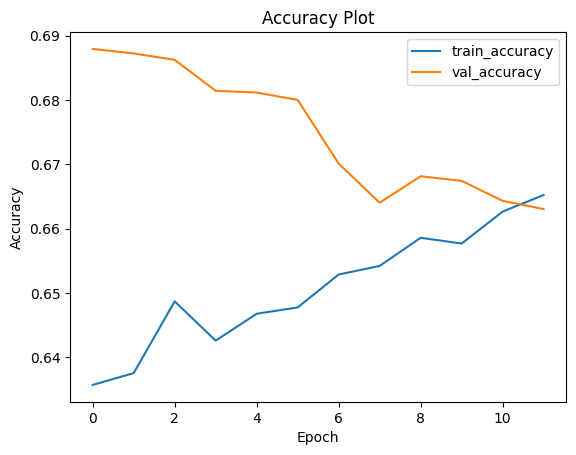

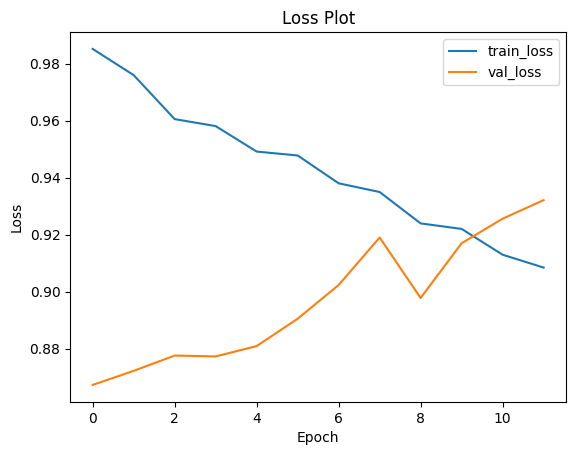

accuracy,▁▁▄▃▄▄▅▅▆▆▇█
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▇▆▆▅▅▄▃▂▂▁▁
val_accuracy,███▆▆▆▃▁▂▂▁▁
val_loss,▁▂▂▂▂▄▅▇▄▆▇█
accuracy,0.66522
best_epoch,0
best_val_loss,0.86723
epoch,11
loss,0.90843
val_accuracy,0.66303


In [22]:
import scipy
import tensorflow as tf
from wandb.keras  import WandbCallback

class Model:
    img_size = 48
    num_classes = 7
    root_path = "./data/fer2"
    batch_size = 64
    epochs = 100
    learning_rate=0.00036156986755960413
    postfix = ""
    path = "/fine-tune/v2"

    def __init__(self):
        self.model = None

    def build_model(self):
        build_model(self)

    def train_model(self, another_callback=[]):
        train_model(self, another_callback)

    def save_model(self, _path):
        save_model(self, _path)

if __name__ == "__main__":
    img_size = 48
    num_classes = 7
    root_path = "./data/fer2"
    batch_size = 64
    epochs = 100
    learning_rate=0.00036156986755960413
    postfix = ""
    wandb.init(project="fyp-fer-fine-tune", entity="johnkhw")
    wandb.config = {
        learning_rate,
        epochs,
        batch_size
    }
    wandb_callback = [
        WandbCallback(),
    ]
    model = Model()
    model.build_model()
    model.train_model(wandb_callback)
    model.save_model('_v3')
    wandb.finish()

In [4]:

from tensorflow import keras

model1 = keras.models.load_model('./data/fer/model.h5')
model = keras.models.load_model('./data/fer2/model_v1.h5')
model1.summary()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 6400)              0         
                                                                 
 dense_20 (Dense)            (None, 128)             